# Plots the Foreground and Background Spectra after Separating the Lens

In [2]:
# imports
import os
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import seaborn as sb

from astropy.table import Table

In [3]:
# Set some plotting environment variables
sb.set(style='white', context='notebook', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

In [4]:
def plotDesiSpectra(coaddPath, ax=None):
    '''
    Plots desi spectra from a coadd file
    
    coaddSpec [desispec] : desispec spectra object to plot
    '''
    from desispec.io import read_spectra
    from astropy.convolution import convolve, Gaussian1DKernel
    
    coaddSpec = read_spectra(coaddPath)
    
    if not ax:
        fig, ax = plt.subplots(figsize = (20, 6))
    
    # Plot the spectrum from each arm (B,R,Z) in blue, green, red
    ax.plot(coaddSpec.wave['b'], coaddSpec.flux['b'][0], color = 'b', alpha = 0.5)
    ax.plot(coaddSpec.wave['r'], coaddSpec.flux['r'][0], color = 'g', alpha = 0.5)
    ax.plot(coaddSpec.wave['z'], coaddSpec.flux['z'][0], color = 'r', alpha = 0.5)
    
    # Over-plotting smoothed spectra in black for all the three arms
    ax.plot(coaddSpec.wave['b'], convolve(coaddSpec.flux['b'][0], Gaussian1DKernel(5)), color = 'k')
    ax.plot(coaddSpec.wave['r'], convolve(coaddSpec.flux['r'][0], Gaussian1DKernel(5)), color = 'k')
    ax.plot(coaddSpec.wave['z'], convolve(coaddSpec.flux['z'][0], Gaussian1DKernel(5)), color = 'k')
    ax.set_xlim([3500, 9900])
    ax.set_xlabel('$\lambda$ [$\AA$]')
    ax.set_ylabel('F$_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')

In [5]:
outdir = '/global/cfs/cdirs/desi/users/nrfran/speclens/'

INFO:spectra.py:291:read_spectra: iotime 0.028 sec to read coadd-sv3-bright-25964-out.fits at 2022-11-15T18:48:39.270876


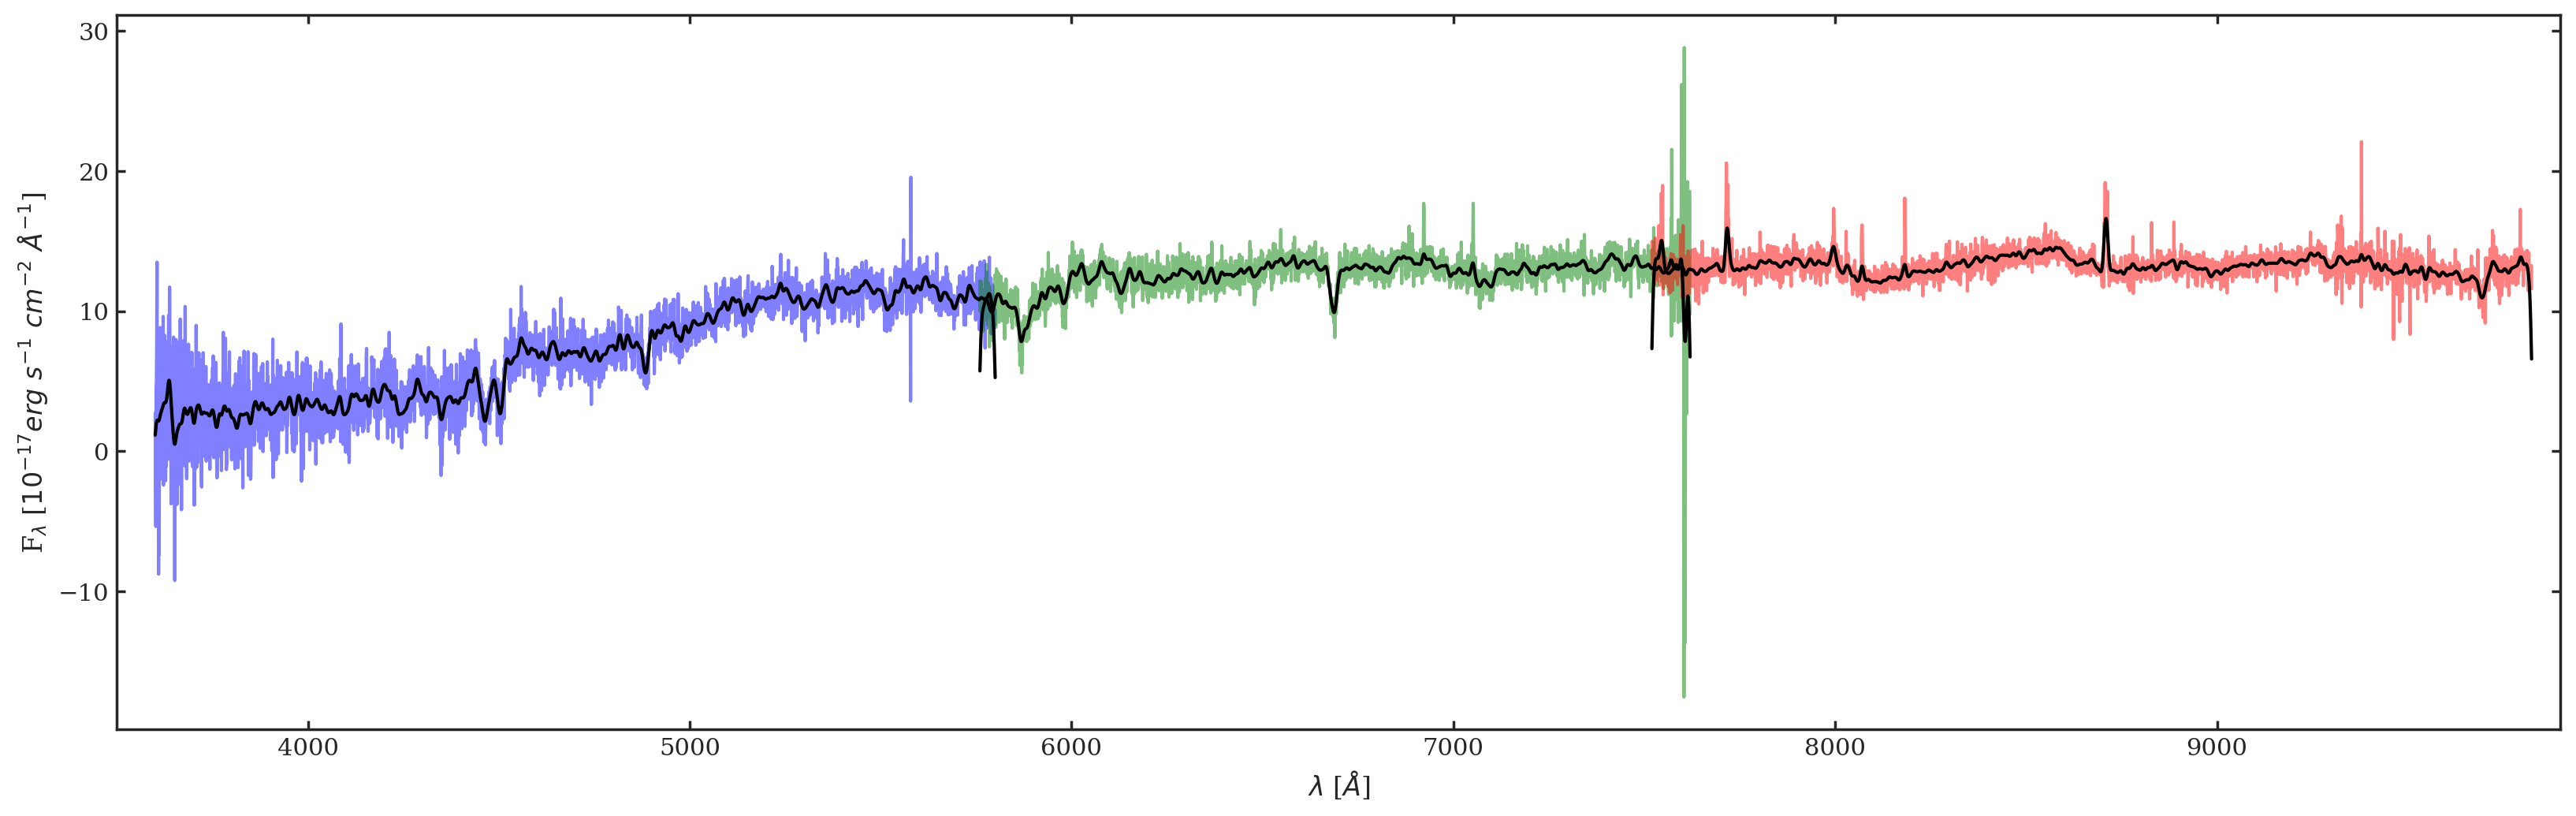

In [10]:
# plot the original spectrum
orig = os.path.join(outdir, 'coadd-sv3-bright-25964-out.fits')
plotDesiSpectra(orig)

## First Foreground

In [37]:
def plotFastspecModel(fastfile, ax=None):
    
    from astropy.table import Table
    import fitsio
    
    model = Table(fitsio.read(fastfile, ext='MODELS'))
    
    return models, hdr

In [38]:
foregroundpath = os.path.join(outdir, 'fastspec-sv3-bright-25964-out.fits')
plotFastspecModel(foregroundpath)

OSError: extension not found: models (case insensitive)

In [12]:
help(fitsio.read)

Help on function read in module fitsio.fitslib:

read(filename, ext=None, extver=None, columns=None, rows=None, header=False, case_sensitive=False, upper=False, lower=False, vstorage='fixed', verbose=False, trim_strings=False, **keys)
    Convenience function to read data from the specified FITS HDU
    
    By default, all data are read.  For tables, send columns= and rows= to
    select subsets of the data.  Table data are read into a recarray; use a
    FITS object and read_column() to get a single column as an ordinary array.
    For images, create a FITS object and use slice notation to read subsets.
    
    Under the hood, a FITS object is constructed and data are read using
    an associated FITSHDU object.
    
    parameters
    ----------
    filename: string
        A filename.
    ext: number or string, optional
        The extension.  Either the numerical extension from zero
        or a string extension name. If not sent, data is read from
        the first HDU that has 